## Smoothing by curve fitting

One approach to smoothing noisy data is to imagine fitting a polynomial at each data point, $x_i$, using a fixed number of points around it. The smoothed value is then the value of the polynomial at that point.

The choices to make then are the degree of the polynomial and the number of neighbouring points to use. The example below illustrates the calculation of the smoothed value for a single point (the red circle) by fitting a quadratic to 5 points (with the point of interest, $x_i$, at the center).

Note that in the illusration I'm using hard-coded, precalculated values for the curve fit parameters, and these only apply to that single point. A brand new fit would be calculated for the next point, and so on...

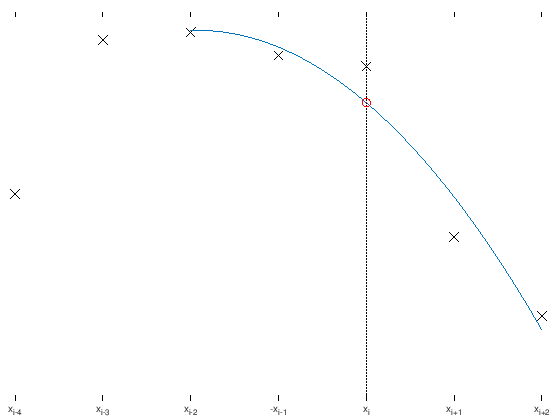

In [1]:
xs=[-4:2];
ys=[6.83 7.82 7.87 7.72 7.65 6.55 6.04];

xs_fit=[-2:0.1:2];
ys_fit=7.416 - 0.483.*xs_fit -0.125.*xs_fit.^2;

hold on;
scatter(xs,ys,700,'k','x');
plot(xs_fit, ys_fit);
scatter(0,7.416,600, 'r');
axis("ticx");
set(gca, "yaxislocation", "origin");
set(gca,'xtick',[-4:2]);
set(gca,'xticklabel',{'x_{i-4}','x_{i-3}','x_{i-2}','-x_{i-1}','x_i', 'x_{i+1}', 'x_{i+2}'});
set(gca, "box", "off");

Notice that to calculate the smoothed value (red circle) you only need $b_0$...

$y(x)=b_0+b_1(x-x_i)+b_2(x-x_i)^2$

$y(x_i)=b_0+b_1(x_i-x_i)+b_2(x_i-x_i)^2=b_0$

You can also get the first and second derivatives at the same time:

$y=b_0+b_1x+b_2x^2$ (or, just $y=b_0$ at the point of interest, $x_i$, as shown above)

$y'=b_1+2b_2x$ (or, similarly, just $y'=b_1$ at $x_i$)

$y''=2b_2$

## Least squares fitting by matrices

To do the curve fit you can start with the 5 equations we want to solve (one for each point we're fitting to):

$y(x_i-2):b_0-2b_1+4b_2=7.87$

$y(x_i-1):b_0-b_1+b_2=7.72$

$y(x_i):b_0=7.65$

$y(x_i+1):b_0+b_1+b_2=6.55$

$y(x_i+2)=b_0+2b_1+4b_2=7.72$

...but when you see a collection of equations like this you probably want to put them in matrix form:

$\begin{bmatrix}
1 & -2 & 4 \\
1 & -1 & 1 \\
1 & 0 & 0 \\
1 & 1 & 1 \\
1 & 2 & 4 \\
\end{bmatrix}
\begin{bmatrix}
b_0 \\ b_1 \\ b_2
\end{bmatrix}=
\begin{bmatrix}
7.87 \\ 7.72 \\ 7.65 \\ 6.55 \\ 6.04
\end{bmatrix}$

Or, if we give the matrix and vectors some names: $A$ for the matrix, $\vec b$ for the vector of the curve fit parameters we're trying to find, and $\vec n$ for the noisy values we're fitting to...

$A\vec b=\vec n$

Of course there (probably) isn't a single set of values for $b_0$, $b_1$, and $b_2$ that would satisfy each equation. In matrix terms, this is like saying there's no linear combination of the column vectors in $A$ that would give $\vec n$. Or, in other words, $\vec n$ is not in the vector space defined by the column vectors in $A$.

![](img\vector-space.png)

The best solution (least-squares) can be found by projecting $\vec n$ onto the vector space of $A$ and solving for that instead...

$A\vec b=\vec n_{projA}$

The clever bit is that it's possible to solve this without actually calculating that projection:

* $\vec n - \vec n_{projA}$ is orthogonal to the vector space of $A$ (by definition)
* which means it must also be orthogonal to each column vector in $A$
* which means its projection onto each column vector must be $0$
* so it's dot product with each column vector must be $0$
* so...

$A^T(\vec n - \vec n_{projA})=\vec 0$

Now we can substitute $\vec n_{projA}$ for $A\vec b$ and re-arrange...

$A^T(\vec n - A\vec b)=\vec 0$

$A^T\vec n - A^TA\vec b=\vec 0$

$A^TA\vec b=A^T\vec n$

$\vec b=(A^TA)^{-1}A^T\vec n$

## The Savitsky-Golay filter coefficients

Remember how we said to get the smoothed value you only need the $b_0$ value? Well that means we can get the smoothed value straight out of this equation...

$y(x_i)=b_0$

$y(x_i)=\begin{bmatrix}1 & 0 & 0\end{bmatrix}(A^TA)^{-1}A^T\vec n$

And, because matrix multiplication is associative, we can think of this as a linear combination of that first chunk of the equation ($\begin{bmatrix}1 & 0 & 0\end{bmatrix}(A^TA)^{-1}A^T$) with the noisy values in the original data ($\vec n$). Notice that that first chunk doesn't depend on the original data at all so (somewhat amazingly) this means there's a set of coefficients, $c$, we can calculate upfront without seeing the data and then convolute that with the data!

$c=\begin{bmatrix}1 & 0 & 0\end{bmatrix}(A^TA)^{-1}A^T$

For the second derivative you just multiply by a different vector to get out $2b_2$ instead of $b_0$

$c=\begin{bmatrix}0 & 0 & 2\end{bmatrix}(A^TA)^{-1}A^T$

## Some implementation short-cuts

### 1. Get the second derivative directly

We have complete control over the values in the matrix $A$, (and hence the values in the parameter vector, $\vec b$). They don't *have* to be the values for the polynomial fitting parameters. We could adjust them so that the parameter vector, $\vec b$, gives us the smooth value, the first derivative and second derivative directly... 

$\begin{bmatrix}
y \\ y' \\ y''
\end{bmatrix}=
\begin{bmatrix}
b_0 \\ b_1 \\ 2b_2
\end{bmatrix}$

$y''=2b_2$

$b_2=\frac{y''}{2}$

So, if we substitute this into the equations we used to build the matrix...

$y(x_i-2):y-2y'+4\frac{y''}{2}=7.87$

$y(x_i-1):y-y'+\frac{y''}{2}=7.72$

$y(x_i):y=7.65$

$y(x_i+1):y+y'+\frac{y''}{2}=6.55$

$y(x_i+2)=y+2y'+4\frac{y''}{2}=7.72$

...we get...

$\begin{bmatrix}
1 & -2 & 2 \\
1 & -1 & \frac{1}{2} \\
1 & 0 & 0 \\
1 & 1 & \frac{1}{2} \\
1 & 2 & 2 \\
\end{bmatrix}
\begin{bmatrix}
y \\ y' \\ y''
\end{bmatrix}=
\begin{bmatrix}
7.87 \\ 7.72 \\ 7.65 \\ 6.55 \\ 6.04
\end{bmatrix}$

(Or, more simply, if you half the values in the last column of the original matrix $A$ then $\vec b=\begin{bmatrix}
y \\ y' \\ y''\end{bmatrix}$ directly)

### 2. Ignore the middle column of A

You can think of each column in the matrix $A$ as a model curve. Each model curve is weighted by the relevant parameter in the parameter vector, $\vec b$, and then summed.

$\begin{bmatrix}
1 & -2 & 4 \\
1 & -1 & 1 \\
1 & 0 & 0 \\
1 & 1 & 1 \\
1 & 2 & 4 \\
\end{bmatrix}
\begin{bmatrix}
b_0 \\ b_1 \\ b_2
\end{bmatrix}$

**Model curve 1:** $\begin{bmatrix}
1 \\
1 \\
1 \\
1 \\
1
\end{bmatrix}$ ...weighted by $b_0$... $\begin{bmatrix}
b_0 \\
b_0 \\
b_0 \\
b_0 \\
b_0
\end{bmatrix}$ ...adds a constant value.

**Model curve 2:** $\begin{bmatrix}
-2 \\
-1 \\
0 \\
1 \\
2
\end{bmatrix}$ ...weighted by $b_1$... $\begin{bmatrix}
-2b_1 \\
-b_1 \\
0 \\
b_1 \\
2b_1
\end{bmatrix}$ ...introduces a slope.

**Model curve 3:** $\begin{bmatrix}
4 \\
2 \\
0 \\
2 \\
4
\end{bmatrix}$ ...weighted by $b_2$... $\begin{bmatrix}
4b_2 \\
2b_1 \\
0 \\
2b_2 \\
4b_2
\end{bmatrix}$ ...adds curvature.

But, because our $x$ values are symmetrical and equally spaced about the centre point (and because we're not interested in the value of the first derivative) we can ignore that model curve. This makes $A$ into a `nx2` matrix instead of `nx3` (where $n$ is the number of points we're using)...

$\begin{bmatrix}
1 & 4 \\
1 & 1 \\
1 & 0 \\
1 & 1 \\
1 & 4 \\
\end{bmatrix}$

That means that $(A^TA)$ is a `2x2` matrix (`(2xn)x(nx2)=(2x2)`) and a `2x2` matrix is very simple to invert.

## Summary

Given all of the above, the values in $(A^TA)$ will look like this:

$(A^TA)=
\begin{bmatrix}
1 & 1 & 1 & 1 & 1 \\
2 & \frac{1}{2} & 0 & \frac{1}{2} & 2 \\
\end{bmatrix}
\begin{bmatrix}
1 & 2 \\
1 & \frac{1}{2} \\
1 & 0 \\
1 & \frac{1}{2} \\
1 & 2 \\
\end{bmatrix}=
\begin{bmatrix}
1 \times 1 + 1 \times 1 + 1 \times 1 + 1 \times 1 + 1 \times 1 & 1 \times 2 + 1 \times \frac{1}{2} + 1 \times 0 + 1 \times \frac{1}{2} + 1 \times 2 \\
2 \times 1 + \frac{1}{2} \times 1 + 0 \times 1 + \frac{1}{2} \times 1 + 2 \times 1 & 2 \times 2 + \frac{1}{2} \times \frac{1}{2} + 0 \times 0 + \frac{1}{2} \times \frac{1}{2} + 2 \times 2
\end{bmatrix}=
\begin{bmatrix}
\sum\limits_{i=-2}^{2}1 & \sum\limits_{i=-2}^{2}\frac{i^2}{2} \\
\sum\limits_{i=-2}^{2}\frac{i^2}{2} & \sum\limits_{i=-2}^{2}\frac{i^4}{4}
\end{bmatrix}$

